<a href="https://colab.research.google.com/github/HungHoangDinh/diffuser/blob/main/DDIM_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q transformers diffusers accelerate

# Setup

In [2]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Useful function for later
def load_image(url, size=None):
    response = requests.get(url,timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Loading an existing pipeline


In [4]:
# Load a pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [5]:
# Set up a DDIM scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

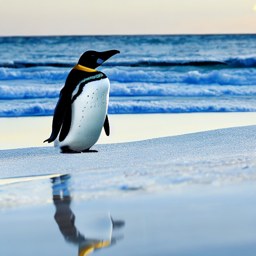

In [6]:
# Sample an image to make sure it is all working
prompt = 'Beautiful DSLR Photograph of a penguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'
im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256)) # Resize for convenient viewing

# DDIM Sampling


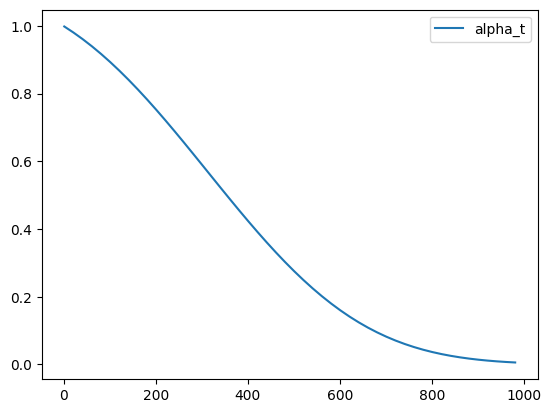

In [7]:
# Plot 'alpha' (alpha_bar in DDPM language, alphas_cumprod in Diffusers for clarity)
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t');
plt.legend();

In [8]:
# Sample function (regular DDIM)
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):

        t = pipe.scheduler.timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1-alpha_t).sqrt()*noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1-alpha_t_prev).sqrt()*noise_pred
        latents = alpha_t_prev.sqrt()*predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:599: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


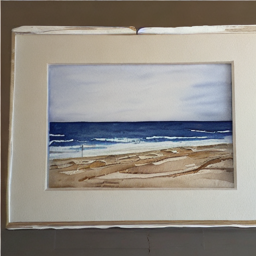

In [9]:
# Test our sampling function by generating an image
sample('Watercolor painting of a beach sunset', negative_prompt=negative_prompt, num_inference_steps=50)[0].resize((256, 256))

# Inversion
The goal of inversion is to ‘reverse’ the sampling process. We want to end up with a noisy latent which, if used as the starting point for our usual sampling procedure, results in the original image being generated.

Here we load an image as our initial image, but you can also generate one yourself to use instead.

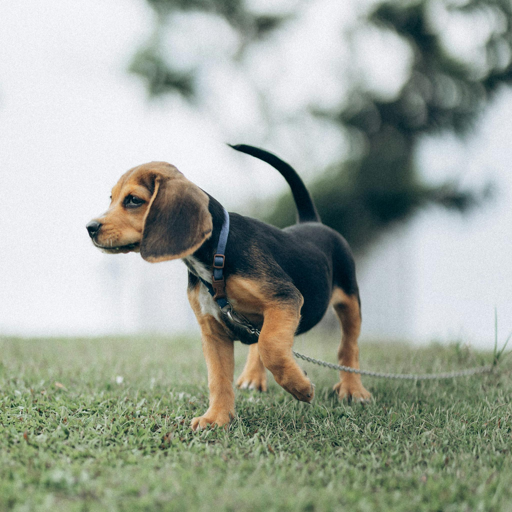

In [10]:
# https://www.pexels.com/photo/a-beagle-on-green-grass-field-8306128/
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
input_image

We’re also going to use a prompt to do the inversion with classifier-free-guidance included, so enter a description of the image:

In [11]:
input_image_prompt = "Photograph of a puppy on the grass"

Next, we need to turn this PIL image into a set of latents which we will use as the starting point for our inversion:



In [12]:
# Encode with VAE
with torch.no_grad():
  latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
l = 0.18215 * latent.latent_dist.sample()

In [13]:
## Inversion
@torch.no_grad()
def invert(start_latents, prompt, guidance_scale=3.5, num_inference_steps=80,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1: continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000//num_inference_steps)) #t
        next_t = t # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1-alpha_t).sqrt()*noise_pred)*(alpha_t_next.sqrt()/alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred


        # Store
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)

In [14]:
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([48, 4, 64, 64])

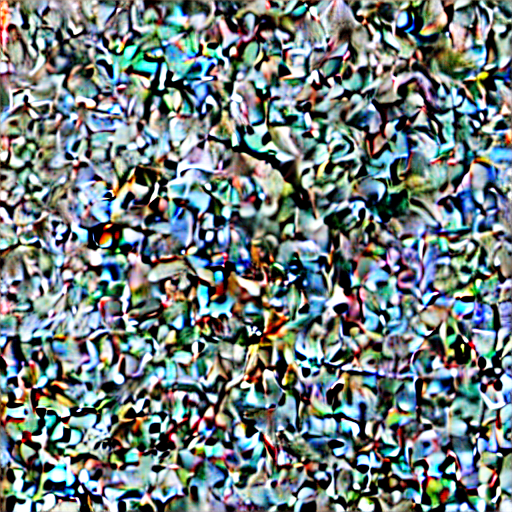

In [15]:
# Decode the final inverted latents
with torch.no_grad():
  im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

You can pass these inverted latents to the pipeline using the normal call method:



  0%|          | 0/50 [00:00<?, ?it/s]

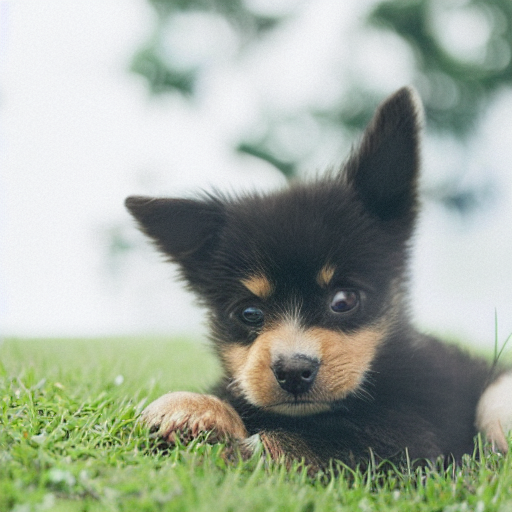

In [16]:
pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=3.5).images[0]

But here we see our first problem: this is not quite the image we started with! This is because DDIM inversion relies on a critical assumption that the noise prediction at time t and at time t+1 will be the same - something that is not true when we only invert over 50 or 100 timesteps. We could use more timesteps to hopefully get a more accurate inversion, but we can also ‘cheat’ and start from, say, 20/50 steps through sampling with the corresponding intermediate latents we saved during inversion:



  0%|          | 0/30 [00:00<?, ?it/s]

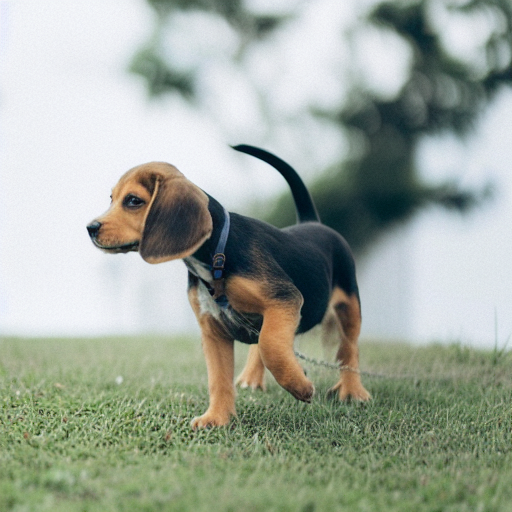

In [17]:
# The reason we want to be able to specify start step
start_step = 20
sample(input_image_prompt, start_latents=inverted_latents[-(start_step+1)][None],
       start_step=start_step, num_inference_steps=50)[0]

Pretty close to our input image! Why are we doing this? Well, the hope is that if we now sample with a new prompt we’ll get an image that matches the original EXCEPT in places relevant to the new prompt. For ex, replacing ‘puppy’ with ‘cat’ we should see a cat with a near-identical lawn and backgorund:

  0%|          | 0/40 [00:00<?, ?it/s]

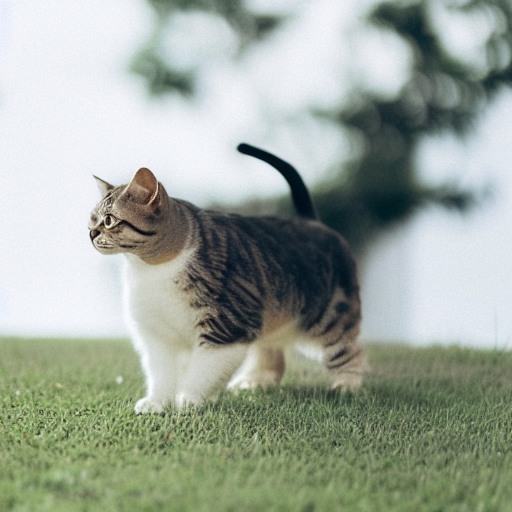

In [18]:
# Sampling with a new prompt
start_step = 10
new_prompt = input_image_prompt.replace('puppy', 'cat')
sample(new_prompt, start_latents=inverted_latents[-(start_step+1)][None],
       start_step=start_step, num_inference_steps=50)[0]

# Why not just use img2img?
Why bother inverting? Can’t we just add noise to the input image and denoise with the new prompt? We can, but this will result in much more drastic changes everywhere (if we add lots of noise) or not enough changes anywhere (if we add less noise). Try it yourself:

  0%|          | 0/40 [00:00<?, ?it/s]

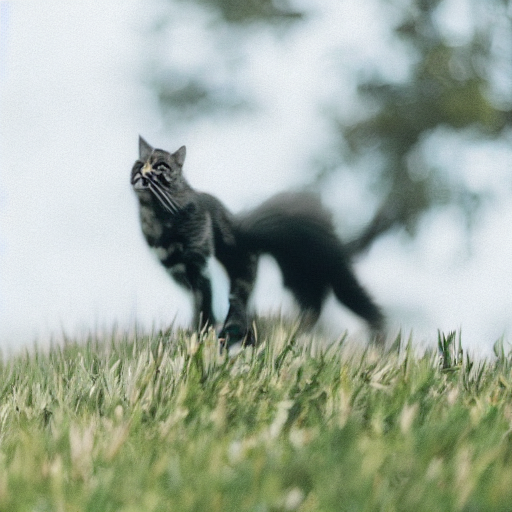

In [19]:
start_step = 10
num_inference_steps = 50
pipe.scheduler.set_timesteps(num_inference_steps)
noisy_l = pipe.scheduler.add_noise(l, torch.randn_like(l), pipe.scheduler.timesteps[start_step])
sample(new_prompt, start_latents=noisy_l, start_step=start_step, num_inference_steps=num_inference_steps)[0]

# Putting it all together


In [20]:
def edit(input_image, input_image_prompt, edit_prompt, num_steps=100, start_step=30, guidance_scale=3.5):
    with torch.no_grad(): latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    final_im = sample(edit_prompt, start_latents=inverted_latents[-(start_step+1)][None],
                      start_step=start_step, num_inference_steps=num_steps, guidance_scale=guidance_scale)[0]
    return final_im

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

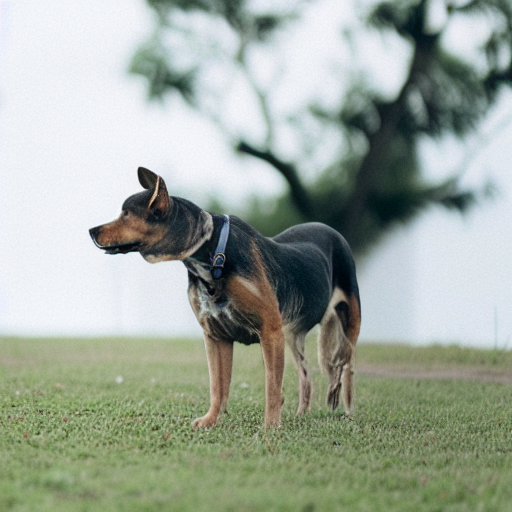

In [21]:
edit(input_image, 'A puppy on the grass', 'an old grey dog on the grass', num_steps=50, start_step=10)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

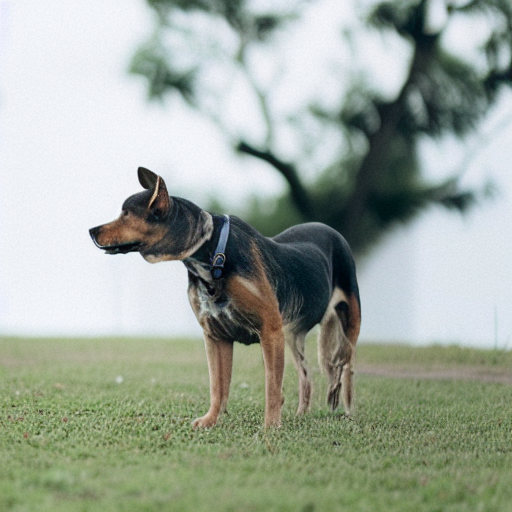

In [22]:
edit(input_image, 'A puppy on the grass', 'an old grey dog on the grass', num_steps=50, start_step=10)

# More Steps = Better Performance


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

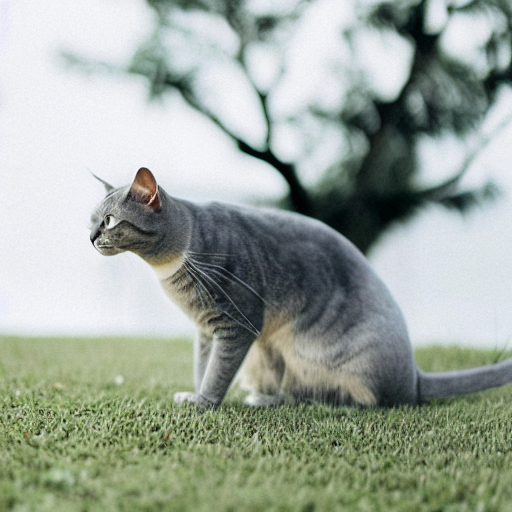

In [23]:
edit(input_image, 'A photograph of a puppy', 'A photograph of a grey cat', num_steps=150, start_step=30, guidance_scale=5.5)